In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns

In [2]:
# Check if this file is Mounted to the right folder
# Otherwise, set it to the desired working directory

working_directory = os.getcwd()
desired_directory = '/content/drive/Shareddrives/DAT 490 Capstone/DAT 490 Capstone/EDA'

if working_directory != desired_directory:
  print("Mounting Drive ...\n")
  # mount Google Drive so Collab can access the dataset
  from google.colab import drive
  drive.mount('/content/drive', force_remount = True)

  # set the working directory
  %cd /content/drive/Shareddrives/'DAT 490 Capstone'/'DAT 490 Capstone'/EDA/
else:
  print(f"Working directory set to {desired_directory}")

Mounting Drive ...

Mounted at /content/drive
/content/drive/Shareddrives/DAT 490 Capstone/DAT 490 Capstone/EDA


In [3]:
other_data_folder = 'Other Data/'

uof_crime_df = pd.read_csv(other_data_folder + "uof_and_crime_data_merged.csv")

dict_uof_utilized_weights = { # each type of uof is weighted according to its severity
    "Use of Force Utilized - Deadly Physical Force" : 1,
    "Use of Force Utilized – Direct Impact Munitions" : 1,
    "Use of Force Utilized - Impact Weapons" : 1,
    "Use of Force Utilized - Pointed Gun at Person" : 1,
    "Use of Force Utilized - Canines" : 1,
    "Use of Force Utilized - Conducted Electrical Weapon (CEW)" : 1,
    "Use of Force Utilized - Irritants" : 1,
    "Use of Force Utilized - Hard Empty Hand" : 1,
    "Use of Force Utilized - Tripping / Tackling" : 1,
    "Use of Force Utilized - Soft Empty Hand" : 0,
    "Use of Force Utilized - Restraining Devices" : 0,
    "Use of Force Utilized - Other" : 0,
}

dict_uof_utilized_weights = { # each type of uof is weighted according to its severity
    "Use of Force Utilized - Deadly Physical Force" : 1,
    "Use of Force Utilized – Direct Impact Munitions" : 1,
    "Use of Force Utilized - Impact Weapons" : 1,
    "Use of Force Utilized - Hard Empty Hand" : 1,
    "Use of Force Utilized - Canines" : 1,
    "Use of Force Utilized - Conducted Electrical Weapon (CEW)" : 0,
    "Use of Force Utilized - Pointed Gun at Person" : 0,
    "Use of Force Utilized - Irritants" : 0,
    "Use of Force Utilized - Tripping / Tackling" : 0,
    "Use of Force Utilized - Soft Empty Hand" : 0,
    "Use of Force Utilized - Restraining Devices" : 0,
    "Use of Force Utilized - Other" : 0,
}

# Iterate over each column in the DataFrame
for column in uof_crime_df.columns:
  # Check if the column is in the dictionary keys
  if column in dict_uof_utilized_weights:
    # Multiply the column values by their corresponding values in the dictionary
    uof_crime_df[column] *= dict_uof_utilized_weights[column]

# Create a column that totals the # of types of UOF used for each record
column_filter_like = 'Use of Force Utilized'
aggregate_col_name = f'\'{column_filter_like}\' Severity'

uof_crime_df[aggregate_col_name] = uof_crime_df.filter(like=column_filter_like).sum(axis=1)
#uof_crime_df[aggregate_col_name] = uof_crime_df[aggregate_col_name]/uof_crime_df[aggregate_col_name].max()
uof_crime_df[aggregate_col_name] = uof_crime_df[aggregate_col_name].apply(lambda x: 1 if x >= 1 else 0)

for column in uof_crime_df.columns:
  # Check if the column is in the dictionary keys
  if column in dict_uof_utilized_weights:
    uof_crime_df = uof_crime_df.drop(column, axis=1)

uof_crime_df[aggregate_col_name].value_counts()

'Use of Force Utilized' Severity
0    1285
1    1052
Name: count, dtype: int64

In [8]:
columns_selected = ['Day of Week',
                    #'Hour',
                    'Police Precinct',
                    'Police Beat',
                    'Individual Gender', 'Individual Age Grouped',
                    'Individual Race', 'Individual  Ethnicity',
                    'Individual Race / Ethnicity Grouping',
                    'Police Employee Race / Ethnicity Grouping',
                    'Police Employee Gender / Sex',
                    'Individual Resistance - Aggravated Active Aggression',
                    'Individual Resistance -Active Aggression',
                    'Individual Resistance -Active Resistance',
                    'Individual Resistance -Passive Resistance',
                    'Individual Resistance -Psychological Intimidation',
                    'Individual Resistance -Verbal Non Compliance',
                    'Individual Resistance - None', 'Individual Armed With -Gun',
                    'Individual Armed with - Cutting Instrument',
                    'Individual Armed With - Blunt Instrument',
                    'Individual Armed With - Other', 'Individual Armed With - No Weapon',
                    'Uniform Crime Reporting (UCR) crime type',
                    'Type of Location/Premise',
                    '\'Use of Force Utilized\' Severity']

categorical_columns = columns_selected[:-1]
columns_need_encoding = [col for col in categorical_columns if 'Individual Resistance' not in col and 'Individual Armed' not in col]

uof_crime_columns_selected = uof_crime_df[columns_selected]
uof_crime_encoded = uof_crime_columns_selected.copy()

from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the categorical columns
one_hot_encoded = one_hot_encoder.fit_transform(uof_crime_encoded[columns_need_encoding])

# Get the column names after one-hot encoding
one_hot_column_names = one_hot_encoder.get_feature_names_out(columns_need_encoding)

# Create a DataFrame from the one-hot encoded array
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_column_names).astype(int)

# Concatenate the one-hot encoded DataFrame with the non-categorical columns
uof_crime_encoded = pd.concat([uof_crime_encoded.drop(columns=columns_need_encoding), one_hot_encoded_df], axis=1)

# move column 'Use of Force Utilized' Severity to the front
severity_column = uof_crime_encoded['\'Use of Force Utilized\' Severity']
uof_crime_encoded.drop(columns=['\'Use of Force Utilized\' Severity'], inplace=True)
uof_crime_encoded.insert(0, '\'Use of Force Utilized\' Severity', severity_column)

In [9]:
for col in uof_crime_encoded.columns:
  print(col)

'Use of Force Utilized' Severity
Individual Resistance - Aggravated Active Aggression
Individual Resistance -Active Aggression
Individual Resistance -Active Resistance
Individual Resistance -Passive Resistance
Individual Resistance -Psychological Intimidation
Individual Resistance -Verbal Non Compliance
Individual Resistance - None
Individual Armed With -Gun
Individual Armed with - Cutting Instrument
Individual Armed With - Blunt Instrument
Individual Armed With - Other
Individual Armed With - No Weapon
Day of Week_1-SUNDAY
Day of Week_2-MONDAY
Day of Week_3-TUESDAY
Day of Week_4-WEDNESDAY
Day of Week_4-WEDNESSDAY
Day of Week_5-THURSDAY
Day of Week_6-FRIDAY
Day of Week_7-SATURDAY
Police Precinct_Black Mountain Precinct
Police Precinct_Black Mountain Precinct Precinct
Police Precinct_Cactus Park Precinct
Police Precinct_Cactus Park Precinct Precinct
Police Precinct_Central City Precinct
Police Precinct_Central City Precinct Precinct
Police Precinct_Desert Horizon Precinct
Police Precinc

In [11]:
uof_crime_encoded.to_csv(other_data_folder + "uof_severity_one_hot_model_data.csv", index=False)

In [12]:
len(uof_crime_encoded.columns)

235

Best Hyperparameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5}

Accuracy: 0.752


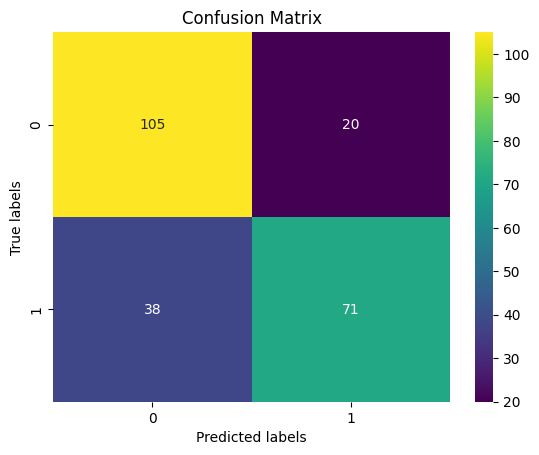

In [ ]:
# import ML libraries:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV

# set X and y
X = uof_crime_encoded.drop(columns=[aggregate_col_name])
y = uof_crime_encoded[aggregate_col_name]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

param_grid = {
    'max_depth': [5, 10, 15],  # Adjust as needed
    'min_samples_split': [2, 5, 10],  # Adjust as needed
    'min_samples_leaf': [1, 5, 10]  # Adjust as needed
}

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_rf_classifier = grid_search.best_estimator_

# Make predictions on the test data using the best model
y_pred = best_rf_classifier.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", round(accuracy, 3))

#Calculate Performance confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap="viridis", fmt='g', alpha=1)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.title('Confusion Matrix')
plt.show()

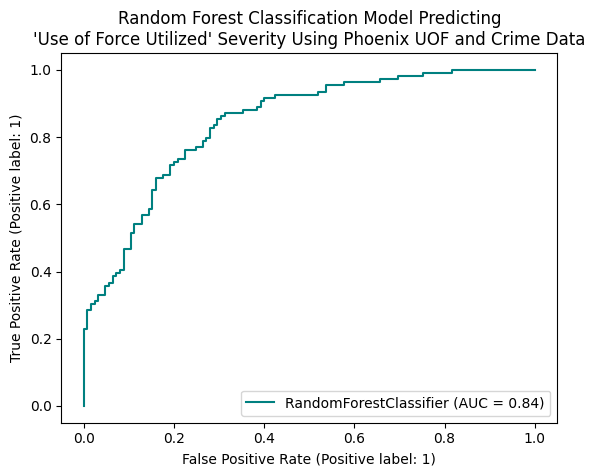

In [ ]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(best_rf_classifier, X_test, y_test, color = 'teal')
plt.title(f"Random Forest Classification Model Predicting\n{aggregate_col_name} Using Phoenix UOF and Crime Data",
          fontsize = 12)
# Save the plot to file
plt.savefig('Plots/rnf_classifier_roc_auc.jpeg', dpi = 350)

In [ ]:
# Get feature importances
feature_importances = pd.Series(best_rf_classifier.feature_importances_, index=X.columns)

# Sort feature importances in descending order
sorted_feature_importances = feature_importances.sort_values(ascending=False)

n_top_features = 10
if n_top_features > len(sorted_feature_importances):
  n_top_features =  len(sorted_feature_importances)

# Print feature importances
print(f"Feature importances (Top {n_top_features}):\n------------------------------")
#print(sorted_feature_importances.head(n_top_features))

top_features_importances_list = list(sorted_feature_importances.head(n_top_features).index)
for index_item, val in zip(top_features_importances_list,
                           list(sorted_feature_importances.head(n_top_features))):
  print(f"- {index_item}: {np.round(val, 2)}")

print(f"\nFeature importances (Bottom {n_top_features}):\n------------------------------")

bottom_features_importances_list = list(sorted_feature_importances.tail(n_top_features).index)
for index_item, val in zip(bottom_features_importances_list,
                           list(sorted_feature_importances.tail(n_top_features))):
  print(f"- {index_item}: {np.round(val, 2)}")

Feature importances (Top 10):
------------------------------
- Uniform Crime Reporting (UCR) crime type_DRUG OFFENSE: 0.05
- Individual Armed With -Gun: 0.03
- Individual Resistance -Active Resistance: 0.03
- Uniform Crime Reporting (UCR) crime type_LARCENY-THEFT: 0.03
- Individual Resistance - Aggravated Active Aggression: 0.03
- Uniform Crime Reporting (UCR) crime type_AGGRAVATED ASSAULT: 0.03
- Type of Location/Premise_SINGLE FAMILY HOUSE: 0.02
- Police Precinct_Desert Horizon Precinct: 0.02
- Individual Resistance -Active Aggression: 0.02
- Individual Resistance -Passive Resistance: 0.02

Feature importances (Bottom 10):
------------------------------
- Type of Location/Premise_LIQUOR STORE: 0.0
- Type of Location/Premise_JAIL / PRISON / PENITENTIARY: 0.0
- Type of Location/Premise_LOAN / FINANCE COMPANY: 0.0
- Type of Location/Premise_FIELD/WOODS: 0.0
- Individual Gender_Unknown: 0.0
- Individual Age Grouped_80s: 0.0
- Type of Location/Premise_CONSTRUCTION SITE: 0.0
- Individual A

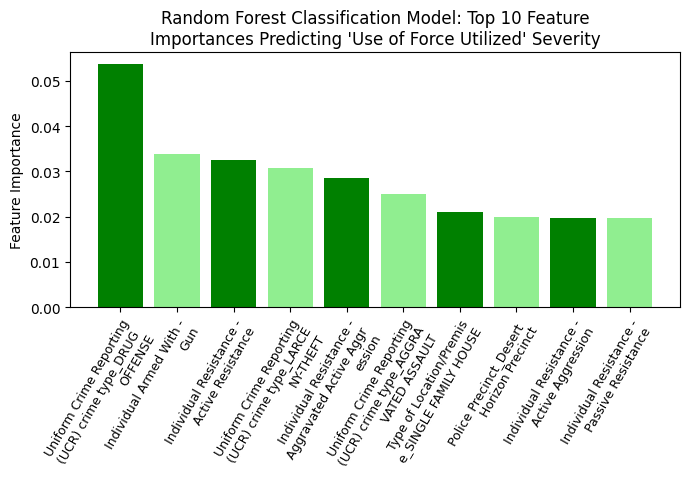

In [ ]:
# For splitting long strings and adding '\n' to create a multi-line string
def split_string_recursive(stringg, char_limit = 23):
    # Base case: if the string length is less than the character limit, return the string
    if len(stringg) <= char_limit:
        return stringg

    # Split the string into two parts at the character limit
    chunk1 = stringg[:char_limit]
    chunk2 = stringg[char_limit:]

    # Recursively split the second part of the string
    rest_of_stringg = split_string_recursive(chunk2, char_limit)

    # Concatenate the first chunk with the result of the recursive call
    return chunk1 + '\n' + rest_of_stringg

colorzz = ['green', 'lightgreen']

# Plot the feature importances
display_top_features = top_features_importances_list.copy()
for index in range(len(display_top_features)):
  display_top_features[index] = split_string_recursive(top_features_importances_list[index])

plt.figure(figsize=(7, 5), dpi = 100)
plt.bar(range(n_top_features), sorted_feature_importances.head(n_top_features),
        align="center", color = colorzz)
plt.xticks(range(n_top_features), display_top_features,
           rotation = 60, fontsize = 9, ha='right', rotation_mode='anchor')
plt.ylabel("Feature Importance", fontsize = 10)
plt.title(f"Random Forest Classification Model: Top {n_top_features} Feature\nImportances Predicting {aggregate_col_name}",
          fontsize = 12)
plt.tight_layout()
plt.savefig('Plots/rnf_classifier_feature_importances.jpeg', dpi = 350)

plt.show()


### **Explaining Methods:**
#### What Did I just do?
- Linked UOF incidents with City of Phoenix crime data to expand features
  - Used the incident identifier primary key to get the intersect records between crime and uof data
  - got 2K rows, which is limiting but we can work with it
- From the joined DF, we picked out some features to use in predicting severity of UOF cases
  - Individual demographic features
  - Officer demographic features
  - Individual resistance
  - Individual armed with
  - Day of the Week
  - Uniform Crime Reporting (UCR) crime type
  - Type of Location/Premise
  - UOF applied
- Feature Engineering:
  - Represented UOF data as a (single feature) binary variable indicating whether it was severe or not
  - One-hot encoded all other categorical data
- Created a Random Forest Model to use this information to classify whether eavh incident would be severe or not
  - Train-test split of 90%-10%
    - This was an intentional split, as the # of records was so limited, adding more data to the train set significantly helped improve model perfomance, measured by AUC
  - Grid search to pick the best hyperparameters: 'max_depth','min_samples_leaf', and 'min_samples_split'
- Evaluated the Random Forest Model
  - Earned an AUC score of 0.81
- Investigated Feature Importances (Top 10-15):
  - Notable, most influential Features:
      - Uniform Crime Reporting (UCR) crime type_DRUG OFFENSE: 0.05
      - Individual Armed With -Gun: 0.03
      - Individual Resistance -Active Resistance: 0.03
      - Uniform Crime Reporting (UCR) crime type_LARCENY-THEFT: 0.03
      - Individual Resistance - Aggravated Active Aggression: 0.03
      - Uniform Crime Reporting (UCR) crime type_AGGRAVATED ASSAULT: 0.03
      - Type of Location/Premise_SINGLE FAMILY HOUSE: 0.02
      - Police Precinct_Desert Horizon Precinct: 0.02
      - Individual Resistance -Active Aggression: 0.02
      - Individual Resistance -Passive Resistance: 0.02

  - Then it was just individual resistance features going down


In [ ]:
# Reorder columns with 'aggregate_col_name' at the front
uof_crime_encoded = uof_crime_encoded[[aggregate_col_name] + [col for col in uof_crime_encoded.columns if col != aggregate_col_name]]
uof_crime_encoded

,'Use of Force Utilized' Severity,Individual Resistance - Aggravated Active Aggression,Individual Resistance -Active Aggression,Individual Resistance -Active Resistance,Individual Resistance -Passive Resistance,Individual Resistance -Psychological Intimidation,Individual Resistance -Verbal Non Compliance,Individual Resistance - None,Individual Armed With -Gun,Individual Armed with - Cutting Instrument,...,Type of Location/Premise_SPECIALTY STORE,Type of Location/Premise_STOREROOM/SHED (RESIDENTIAL),Type of Location/Premise_STREET / ROADWAY / ALLEY / SIDEWALK,Type of Location/Premise_STREET / ROADWAY / SIDEWALK,Type of Location/Premise_THEATRE,Type of Location/Premise_TRAIN STATION,Type of Location/Premise_UNKNOWN,Type of Location/Premise_VEHICLE,Type of Location/Premise_WAREHOUSE / FACTORY,Type of Location/Premise_nan
0,0,0,0,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,1,0,1,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2333,0,0,1,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2334,1,0,1,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2335,0,0,1,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0


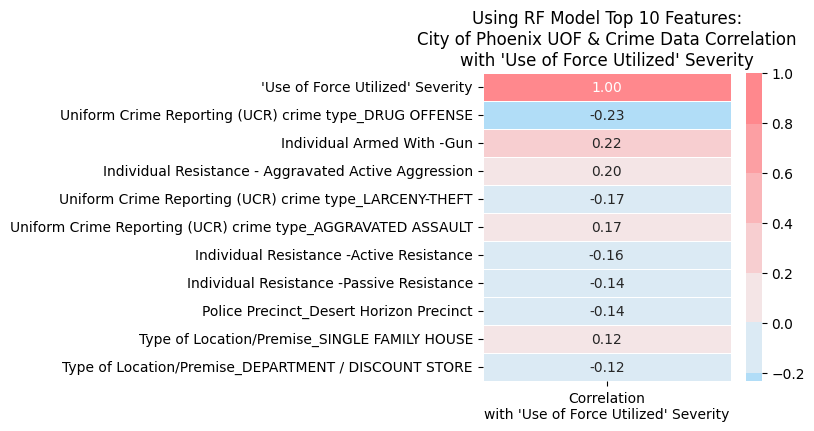

In [ ]:
def evaluate_top_props(list_of_features):

  # Compute the correlation matrix
  correlation_matrix = uof_crime_encoded.corr(numeric_only = True)

  correlation_name = f'Correlation\nwith {aggregate_col_name}'

  # Compute the correlation between the first column ("UOF Utilized Sum") and all other columns
  correlation_with_first_column = correlation_matrix.iloc[0, :].to_frame(name=correlation_name)

  # Sort the correlation series in descending order
  sorted_correlations = correlation_with_first_column.reindex(correlation_with_first_column[correlation_name].abs().sort_values(ascending=False).index)

  # custom colormap for correlation heatmap
  my_custom_cmap = sns.diverging_palette(240, 10, s=100, l=70, n=10)

  # Create the heatmap with positive and negative values
  plt.figure(figsize=(4, 4), dpi=100)

  sns.heatmap(sorted_correlations.head(n_top_features + 1), annot=True, cmap=my_custom_cmap, linewidths=.5, fmt=".2f", center=0)
  plt.title(f'Using RF Model Top {n_top_features} Features:\nCity of Phoenix UOF & Crime Data {correlation_name}')
  plt.savefig('Plots/UOF_Severity_correlation_heat_map.jpeg', dpi=350)
  plt.show()


# this evaluates the correlations with Severe UOF
evaluate_top_props(list(sorted_feature_importances.head(n_top_features).index))

In [ ]:
def evaluate_top_props_2(list_of_features):
  for the_feature in list_of_features:
    value_countss = uof_crime_encoded[uof_crime_df[aggregate_col_name] == 1].groupby(the_feature).size() #.sort_values(ascending=False)
    sum_items = value_countss.sum()

    print()
    display((round(value_countss/sum_items, 3)).head(10))

# this evaluates the class proportions in cases where severe UOF was used
evaluate_top_props_2(list(sorted_feature_importances.head(n_top_features).index))

Uniform Crime Reporting (UCR) crime type_DRUG OFFENSE
0    0.855
1    0.145
dtype: float64

Individual Armed With -Gun
0    0.828
1    0.172
dtype: float64

Individual Resistance -Active Resistance
0    0.428
1    0.572
dtype: float64

Uniform Crime Reporting (UCR) crime type_LARCENY-THEFT
0    0.951
1    0.049
dtype: float64

Individual Resistance - Aggravated Active Aggression
0    0.784
1    0.216
dtype: float64

Uniform Crime Reporting (UCR) crime type_AGGRAVATED ASSAULT
0    0.53
1    0.47
dtype: float64

Type of Location/Premise_SINGLE FAMILY HOUSE
0    0.806
1    0.194
dtype: float64

Police Precinct_Desert Horizon Precinct
0    0.958
1    0.042
dtype: float64

Individual Resistance -Active Aggression
0    0.643
1    0.357
dtype: float64

Individual Resistance -Passive Resistance
0    0.553
1    0.447
dtype: float64

### Discussing/Evaluating Results

#### In Cases of Severe Force (stats about the most influential factors):
- In 60.3% of cases individuals resisted via active resistance
- In 79.8% of cases the crime type was not a drug offense
- In 82% of cases individuals were armed with a weapon

Running the model many times, these 2 factors come on top ^

Other factors:

- In 61.4% of cases individuals resisted via verbal non-compliance
- In 33.9% of cases individuals were in their 30s

The most influential features in our model are pivotal in predicting the severity of use-of-force (UOF) cases. These key variables significantly influence the model's predictions, enabling it to distinguish well between severe and non-severe UOF incidents.
- An interesting observation is that certain crimes are notably absent in the majority of severe UOF cases, at least within this dataset. Identifying which crimes didn't occur proves to be extremely helpful in predicting whether a UOF incident will be severe.

Notes:
- Need to differenciate between active resistance and verbal non-compliance
- Refer to the data dictionary for clarification

## Try again but with another dataset

In [ ]:
# Get the cleaned UOF data

uof_path_folder = 'CPhoenix UOF Data/'
data_relabeled_filepaths_cleaned = glob.glob(f'{uof_path_folder}relabeled/cleaned*.csv', recursive = True) # includes the cleaned columns

def get_cleaned_uof_incident_details_df(which, print_cleaned_col_info = True):
    if which not in range(1, len(data_relabeled_filepaths_cleaned) + 1):
        raise ValueError(f"Parameter must be in range [1, {len(data_relabeled_filepaths_cleaned)}].")

    for filepath in data_relabeled_filepaths_cleaned:
      if f'cleaned_{which}' in filepath:
          cleaned_main_path = filepath
          break

    cleaned_main = pd.read_csv(cleaned_main_path)

    if(print_cleaned_col_info):
        print_ln = "+" * 50
        print(f'{print_ln}\n')
        print('CSV NAME:', cleaned_main_path.rsplit('/', 1)[-1][:-4])
        print(f"\ndf Shape: {cleaned_main.shape}")
        print()
        print('Columns:\n--------------')

        for col, num in zip(cleaned_main.columns, range(1, len(cleaned_main))):
            print(f"{num}: {col}")

        print(f'\n{print_ln}')

    return(cleaned_main)

cleaned_main_uof_df = get_cleaned_uof_incident_details_df(1)

++++++++++++++++++++++++++++++++++++++++++++++++++

CSV NAME: cleaned_1-uof-incident-details

df Shape: (4967, 55)

Columns:
--------------
1: Use of Force Report Number
2: Incident Report Number
3: Police Employee Unique Identifier
4: Unique Individual Record Number 
5: Date
6: Year
7: Hour
8: Day of Week
9: Police Beat
10: Anonymized Address
11: City
12: State
13: Zip Code
14: Police Precinct
15: Individual Injury
16: Individual Gender
17: Individual Age
18: Individual Age Grouped
19: Individual Race
20: Individual  Ethnicity
21: Individual Race / Ethnicity Grouping
22: Police Employee Race / Ethnicity Grouping
23: Police Employee Gender / Sex
24: Individual Resistance - Aggravated Active Aggression
25: Individual Resistance -Active Aggression
26: Individual Resistance -Active Resistance
27: Individual Resistance -Passive Resistance
28: Individual Resistance -Psychological Intimidation
29: Individual Resistance -Verbal Non Compliance
30: Individual Resistance - None
31: Individual Ar

In [ ]:

uof_crime_df = cleaned_main_uof_df.copy()

dict_uof_utilized_weights = { # each type of uof is weighted according to its severity
    "Use of Force Utilized - Deadly Physical Force" : 1,
    "Use of Force Utilized – Direct Impact Munitions" : 1,
    "Use of Force Utilized - Impact Weapons" : 1,
    "Use of Force Utilized - Pointed Gun at Person" : 1,
    "Use of Force Utilized - Canines" : 1,
    "Use of Force Utilized - Conducted Electrical Weapon (CEW)" : 1,
    "Use of Force Utilized - Irritants" : 1,
    "Use of Force Utilized - Hard Empty Hand" : 1,
    "Use of Force Utilized - Tripping / Tackling" : 1,
    "Use of Force Utilized - Soft Empty Hand" : 0,
    "Use of Force Utilized - Restraining Devices" : 0,
    "Use of Force Utilized - Other" : 0,
}

dict_uof_utilized_weights = { # each type of uof is weighted according to its severity
    "Use of Force Utilized - Deadly Physical Force" : 1,
    "Use of Force Utilized – Direct Impact Munitions" : 1,
    "Use of Force Utilized - Impact Weapons" : 1,
    "Use of Force Utilized - Hard Empty Hand" : 1,
    "Use of Force Utilized - Canines" : 1,
    "Use of Force Utilized - Conducted Electrical Weapon (CEW)" : 0,
    "Use of Force Utilized - Pointed Gun at Person" : 0,
    "Use of Force Utilized - Irritants" : 0,
    "Use of Force Utilized - Tripping / Tackling" : 0,
    "Use of Force Utilized - Soft Empty Hand" : 0,
    "Use of Force Utilized - Restraining Devices" : 0,
    "Use of Force Utilized - Other" : 0,
}

dict_uof_utilized_weights = { # each type of uof is weighted according to its severity
    "Use of Force Utilized - Deadly Physical Force" : 1,
    "Use of Force Utilized – Direct Impact Munitions" : 1,
    "Use of Force Utilized - Impact Weapons" : 1,
    "Use of Force Utilized - Hard Empty Hand" : 1,
    "Use of Force Utilized - Canines" : 1,
    "Use of Force Utilized - Conducted Electrical Weapon (CEW)" : 1,
    "Use of Force Utilized - Pointed Gun at Person" : 1,
    "Use of Force Utilized - Irritants" : 1,
    "Use of Force Utilized - Tripping / Tackling" : 1,
    "Use of Force Utilized - Soft Empty Hand" : 1,
    "Use of Force Utilized - Restraining Devices" : 1,
    "Use of Force Utilized - Other" : 1,
}

# Iterate over each column in the DataFrame
for column in uof_crime_df.columns:
  # Check if the column is in the dictionary keys
  if column in dict_uof_utilized_weights:
    # Multiply the column values by their corresponding values in the dictionary
    uof_crime_df[column] *= dict_uof_utilized_weights[column]


# Create a column that totals the # of types of UOF used for each record
column_filter_like = 'Use of Force Utilized'
aggregate_col_name = f'\'{column_filter_like}\' Severity'

uof_crime_df[aggregate_col_name] = uof_crime_df.filter(like=column_filter_like).sum(axis=1)
#uof_crime_df[aggregate_col_name] = uof_crime_df[aggregate_col_name]/uof_crime_df[aggregate_col_name].max()
uof_crime_df[aggregate_col_name] = uof_crime_df[aggregate_col_name].apply(lambda x: 1 if x >= 1 else 0)

for column in uof_crime_df.columns:
  # Check if the column is in the dictionary keys
  if column in dict_uof_utilized_weights:
    uof_crime_df = uof_crime_df.drop(column, axis=1)

uof_crime_df[aggregate_col_name].value_counts()

1    4958
0       9
Name: 'Use of Force Utilized' Severity, dtype: int64

In [ ]:
columns_selected = ['Day of Week',
                    'Police Precinct',
                    'Police Beat',
                    'Individual Injury',
                    'Individual Gender', 'Individual Age Grouped',
                    'Individual Race', 'Individual  Ethnicity',
                    'Individual Race / Ethnicity Grouping',
                    'Police Employee Race / Ethnicity Grouping',
                    'Police Employee Gender / Sex',
                    'Individual Resistance - Aggravated Active Aggression',
                    'Individual Resistance -Active Aggression',
                    'Individual Resistance -Active Resistance',
                    'Individual Resistance -Passive Resistance',
                    'Individual Resistance -Psychological Intimidation',
                    'Individual Resistance -Verbal Non Compliance',
                    'Individual Resistance - None', 'Individual Armed With -Gun',
                    'Individual Armed with - Cutting Instrument',
                    'Individual Armed With - Blunt Instrument',
                    'Individual Armed With - Bodily Force', 'Individual Armed With - Other',
                    'Individual Armed With - No Weapon',
                    'Individual Charged With - Criminal Felony',
                    'Individual Charged With - Criminal Misdemeanor',
                    'Individual Charged With - Criminal Traffic',
                    'Individual Charged With - Civil Traffic',
                    'Individual Charged With - None',
                    'Officer Body Worn Camera Active',
                    'Officer Within Policy',
                    '\'Use of Force Utilized\' Severity']

categorical_columns = columns_selected[:-1]
columns_need_encoding = [col for col in categorical_columns if 'Individual Resistance' not in col and
                                                               'Individual Armed' not in col and
                                                               'Individual Charged' not in col and
                                                               'Officer Within Policy' not in col and
                                                               'Officer Body Worn Camera Active' not in col]

uof_crime_columns_selected = uof_crime_df[columns_selected]
uof_crime_encoded = uof_crime_columns_selected.copy()

from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the categorical columns
one_hot_encoded = one_hot_encoder.fit_transform(uof_crime_encoded[columns_need_encoding])

# Get the column names after one-hot encoding
one_hot_column_names = one_hot_encoder.get_feature_names_out(columns_need_encoding)

# Create a DataFrame from the one-hot encoded array
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_column_names).astype(int)

# Concatenate the one-hot encoded DataFrame with the non-categorical columns
uof_crime_encoded = pd.concat([uof_crime_encoded.drop(columns=columns_need_encoding), one_hot_encoded_df], axis=1)

Best Hyperparameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}

Accuracy: 0.722


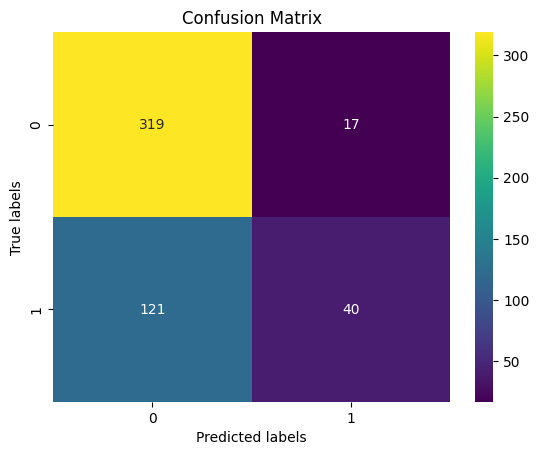

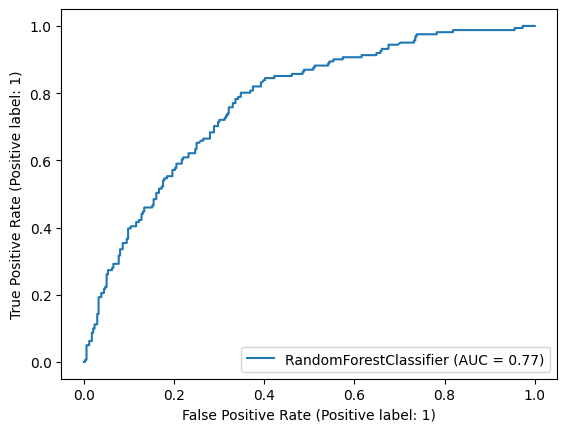

In [ ]:
# import ML libraries:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV

# set X and y
X = uof_crime_encoded.drop(columns=[aggregate_col_name])
y = uof_crime_encoded[aggregate_col_name]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

param_grid = {
    'max_depth': [5, 10, 15],  # Adjust as needed
    'min_samples_split': [2, 5, 10],  # Adjust as needed
    'min_samples_leaf': [1, 5, 10]  # Adjust as needed
}

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_rf_classifier = grid_search.best_estimator_

# Make predictions on the test data using the best model
y_pred = best_rf_classifier.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", round(accuracy, 3))

#Calculate Performance confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap="viridis", fmt='g', alpha=1)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(best_rf_classifier, X_test, y_test)

In [ ]:
# Get feature importances
feature_importances = pd.Series(best_rf_classifier.feature_importances_, index=X.columns)

# Sort feature importances in descending order
sorted_feature_importances = feature_importances.sort_values(ascending=False)

n_top_features = 10
if n_top_features > len(sorted_feature_importances):
  n_top_features =  len(sorted_feature_importances)

# Print feature importances
print(f"Feature importances (Top {n_top_features}):\n------------------------------")
#print(sorted_feature_importances.head(n_top_features))

top_features_importances_list = list(sorted_feature_importances.head(n_top_features).index)
for index_item, val in zip(top_features_importances_list,
                           list(sorted_feature_importances.head(n_top_features))):
  print(f"- {index_item}: {np.round(val, 2)}")

print(f"\nFeature importances (Bottom {n_top_features}):\n------------------------------")

bottom_features_importances_list = list(sorted_feature_importances.tail(n_top_features).index)
for index_item, val in zip(bottom_features_importances_list,
                           list(sorted_feature_importances.tail(n_top_features))):
  print(f"- {index_item}: {np.round(val, 2)}")

Feature importances (Top 10):
------------------------------
- Individual Resistance -Active Resistance: 0.04
- Individual Charged With - Criminal Misdemeanor: 0.04
- Individual Resistance -Active Aggression: 0.04
- Police Employee Race / Ethnicity Grouping_White: 0.02
- Individual Resistance -Psychological Intimidation: 0.02
- Individual Resistance -Passive Resistance: 0.02
- Individual Armed With - Bodily Force: 0.02
- Individual Charged With - Criminal Felony: 0.02
- Police Employee Race / Ethnicity Grouping_Hispanic: 0.02
- Individual Armed with - Cutting Instrument: 0.02

Feature importances (Bottom 10):
------------------------------
- Individual Age Grouped_70s: 0.0
- Individual Age Grouped_80s: 0.0
- Individual Race_Unknown: 0.0
- Individual Race_AmIndian: 0.0
- Police Beat_212 Beat: 0.0
- Individual Race_Hispanic: 0.0
- Individual Age Grouped_90s: 0.0
- Individual Gender_Unknown: 0.0
- Individual Resistance - None: 0.0
- Individual Race_indian: 0.0


In [ ]:
def evaluate_top_props(list_of_features):
  for the_feature in list_of_features:
    value_countss = uof_crime_encoded[uof_crime_df[aggregate_col_name] == 1].groupby(the_feature).size() #.sort_values(ascending=False)
    sum_items = value_countss.sum()

    print()
    display((round(value_countss/sum_items, 3)).head(10))

# this evaluates the class proportions in cases where severe UOF was used
evaluate_top_props(list(sorted_feature_importances.head(n_top_features).index))

Individual Resistance -Active Resistance
0    0.334
1    0.666
dtype: float64

Individual Charged With - Criminal Misdemeanor
0    0.61
1    0.39
dtype: float64

Individual Resistance -Active Aggression
0    0.502
1    0.498
dtype: float64

Police Employee Race / Ethnicity Grouping_White
0    0.376
1    0.624
dtype: float64

Individual Resistance -Psychological Intimidation
0    0.547
1    0.453
dtype: float64

Individual Resistance -Passive Resistance
0    0.466
1    0.534
dtype: float64

Individual Armed With - Bodily Force
0    0.594
1    0.406
dtype: float64

Individual Charged With - Criminal Felony
0    0.144
1    0.856
dtype: float64

Police Employee Race / Ethnicity Grouping_Hispanic
0    0.759
1    0.241
dtype: float64

Individual Armed with - Cutting Instrument
0    0.93
1    0.07
dtype: float64